### 0. 데이터 전처리가 된 후의 데이터를 불러온다

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

df = pd.read_excel('After Data_Preprocessing.xlsx')     # 2번 코드에서 전처리한 데이터(엑셀파일)를 불러온다
df = df.drop('Unnamed: 0', axis=1)                      # 불필요한 column을 삭제
df.head()

,정가,할인가,별점,자극도,상품명_bewants,상품명_editor,상품명_goodal,상품명_prem,상품명_torriden,카테고리_아이크림,...,피부고민2_미백,피부고민2_민감성,피부고민2_블랙헤드,피부고민2_아토피,피부고민2_잡티,피부고민2_주름,피부고민2_탄력,피부고민2_트러블,피부고민2_피지과다,피부고민2_홍조
0,33000,24900,4,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,33000,24900,5,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,33000,24900,5,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,33000,24900,5,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,33000,24900,5,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# 1. 랜덤포레스트

#### 피처값과 타겟값을 지정해줍니다. (target : 별점, 피처는 별점 제외 모든 컬럼)

In [ ]:
# 피처값과 타겟값 지정 (target : 별점, 피처는 별점 제외 모든 컬럼)
features = df.drop("별점", axis=1)
target = df["별점"]

#### 저장한 피처와 타겟을 가지고 train : test 데이터를 8:2로 나누어 줍니다. random_state = 50

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=50)

#### 별점의 분포를 막대그래프로 시각화하여 불균형한지 확인합니다.

<Axes: xlabel='별점'>

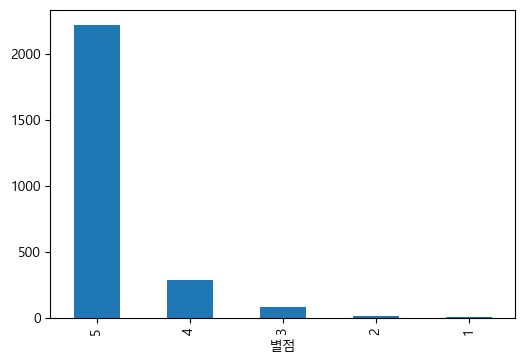

In [ ]:
#한글 깨짐 방지
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

#막대그래프 코드 작성
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="별점")
plt.title("별점 분포")
plt.xlabel("별점")
plt.ylabel("개수")
plt.show()

### 불균형한 데이터 샘플링 SMOTE 활용

In [ ]:
#불균형 데이터 오버샘플링 SMOTE 
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print("SMOTE 적용 전 train 데이터셋 shape : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후 train 데이터셋 shape :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 train 타겟 별점 분포',y_train_over.value_counts() )

SMOTE 적용 전 train 데이터셋 shape :  (2104, 58) (2104,)
SMOTE 적용 후 train 데이터셋 shape : (8915, 58) (8915,)
SMOTE 적용 후 train 타겟 별점 분포 별점
5    1783
4    1783
3    1783
2    1783
1    1783
Name: count, dtype: int64


### 데이터 스케일링
피처의 단위를 동일하게 만들기 위해 StandardScaler로 스케일링을 진행합니다.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_over) # SMOTE를 사용한 후의 데이터를 스케일링
X_test_scaled = scaler.transform(X_test)            # test데이터의 경우에는 SMOTE 적용 X

### 그리드서치로 최적의 파라미터 찾기 
1. 지정할 파라미터와 값을 params에 저장합니다.  
2. 랜덤포레스트 모델을 생성하고 rfc로 할당합니다. (random_state=100, n_jobs=-1)  
3. 그리드서치를 실행하여 grid_cv로 할당합니다. (cv=3, n_jobs=-1)
4. 스케일링 완료한 훈련 데이터를 grid_cv에 fit해줍니다.
5. 최적의 파라미터를 print 합니다.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#각 파라미터 값 넣기
params = {
    'n_estimators': [10, 50, 100, 150],         # 랜덤 포레스트에서 생성할 트리 개수
    'max_depth': [None, 5, 10, 15, 20],         # 트리의 최대 깊이(너무 깊으면 overfitting 우려)
    'max_features': [5, 10, 20, 30, 40, 50],    # 각 트리가 분할에 사용할 최대 특성의 개수
    'min_samples_split': [2, 5, 10, 15, 20]     # 노드를 분할하기 위한 최소 샘플 수
}

rfc = RandomForestClassifier(random_state=100, n_jobs=-1)
grid_search = GridSearchCV(rfc, param_grid=params, cv=3, n_jobs=-1)     # cv는 교차 검증을 위해 분할되는 학습 데이터의 세트 수
grid_search.fit(X_train_scaled, y_train_over) 

print(f'최적 파라미터: {grid_search.best_params_}') # 선택된 최적의 파라미터를 출력

최적 파라미터: {'max_depth': 5, 'max_features': 50, 'min_samples_split': 20, 'n_estimators': 70}


### 랜덤포레스트 모델 훈련
위에서 구한 최적 파라미터를 활용하여 랜덤포레스트 모델을 만들고 해당 모델로 다시 훈련시킵니다. random_state=100, n_jobs=-1

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(max_depth=5, max_features=50, min_samples_split=20, n_estimators=50, n_jobs=-1, random_state=100)
rfc.fit(X_train_scaled, y_train_over) # 학습 데이터로 최적의 하이퍼 파라미터로 만들어진 RF모델의 학습 진행

RandomForestClassifier(max_depth=5, max_features=50, min_samples_split=20,
                       n_estimators=50, n_jobs=-1, random_state=100)

 ### 모델 평가지표 결과값이 한번에 나오도록 함수 만들기
 함수에 y_test와 pred를 입력하면 정확도, 정밀도, 재현율, f1스코어가 데이터 프레임으로 나오도록 함수를 만듭니다.  
 단, 정확도, 정밀도, 재현율, f1스코어의 average는 모두 'micro'로 설정  
 딕셔너리를 활용하여 데이터 프레임을 만들어주세요.  

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

def _metrics(y_test, pred):
    acc= accuracy_score(y_test, pred)
    precision= precision_score(y_test, pred, average='micro')
    recall= recall_score(y_test, pred, average='micro')
    f1= f1_score(y_test, pred, average='micro')
    
    dict_metrics= {
        'Accuracy': acc,
        'Precision' : precision,
        'Recall' : recall,
        'F1' : f1
    }
    df_metrics=pd.DataFrame(dict_metrics, index = [0]) # index를 [0]으로 설정하여 결과를 단일 행렬로 저장한다
    
    return df_metrics

#### 스케일링한 test데이터를 가지고 모델에 적용하여 나온 예측값을 pred에 할당하고 평가지표함수로 성능을 확인합니다.

In [ ]:
pred = rfc.predict(X_test)
_metrics(y_test, pred)

,accuracy,precision,recall,f1
0,0.521,0.521,0.521,0.521


### 혼동행렬
y_test와 예측값 pred를 이용하여 혼동행렬 생성하여 cf에 할당합니다.

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, pred)
cf

array([[  1,   0,   1,   0,   1],
       [  1,   1,   1,   1,   0],
       [  1,   1,   7,   2,   7],
       [  4,   4,   9,  15,  26],
       [  5,  19,  42, 127, 250]], dtype=int64)

### 혼동행렬 시각화
cf를 데이터 프레임(cf_matrix)으로 만든 후 컬럼명과, 인덱스를 1~5점으로 저장합니다.   
데이터 프레임을 heatmap으로 만들어 줍니다. ( anno=True  -> 각 셀에 숫자 입력 , fmt='d'  -> 정수형으로 나오도록함)   
x라벨 : 예측값, y라벨 : 실제값

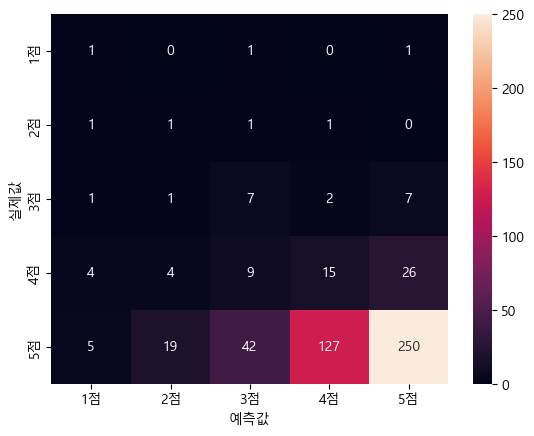

In [ ]:
labels = [1, 2, 3, 4, 5]
sns.heatmap(cf, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel("예측값")
plt.ylabel("실제값")
plt.show()

# 2. KNN

### 랜덤포레스트와 데이터 스케일링까지 과정이 반복됨

#### 피처값과 타겟값  (target : 별점, 피처는 별점 제외 모든 컬럼)

In [ ]:
features = df.drop("별점", axis=1)
target = df["별점"]

#### 저장한 피처와 타겟을 가지고 train : test 데이터를 8:2로 나누어 줍니다. random_state = 50

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=50)

#### 불균형 데이터 smote로 오버샘플링

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

#### 피처의 단위를 동일하게 만들기 위해 StandardScaler로 스케일링을 진행합니다.

In [ ]:
from sklearn.preprocessing import StandardScaler
      
X_train_scaled = scaler.fit_transform(X_train_over) # SMOTE를 사용한 후의 데이터를 스케일링
X_test_scaled = scaler.transform(X_test)            # test데이터의 경우에는 SMOTE 적용 X

### 그리드서치로 최적의 파라미터 찾기 
1. 지정할 파라미터와 값을 knn_params에 저장합니다.  
2. KNN 모델을 생성하고 knn으로 할당합니다. (n_jobs=-1)  
3. 그리드서치를 실행하여 grid_cv로 할당합니다. (cv=5, n_jobs=-1)
4. 스케일링 완료한 훈련 데이터를 grid_cv에 fit해줍니다.
5. 최적의 파라미터를 print 합니다.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#각 파라미터 값 넣기
knn_params = {
    'n_neighbors' : [3, 5, 7, 9],
    'weights' : ['uniform', 'distance']
}

knn= KNeighborsClassifier(random_state=100, n_jobs=-1)
grid_search=GridSearchCV(knn, param_grid=params, cv=3, n_jobs=-1)   # cv는 교차 검증을 위해 분할되는 학습 데이터의 세트 수     
grid_search.fit(X_train_scaled,y_train_over)

print(f'최적 하이퍼 파라미터: {grid_search.best_params_}') # 선택된 최적의 파라미터를 출력

최적 하이퍼 파라미터: {'n_neighbors': 7, 'weights': 'distance'}


### KNN 모델 훈련
위에서 구한 최적 파라미터를 활용하여 knn 모델을 만들고 해당 모델로 다시 훈련시킵니다. n_jobs=-1

In [ ]:
knn= KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='distance')
knn.fit(X_train_scaled,y_train_over)

KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='distance')

#### 스케일링한 test데이터를 가지고 모델에 적용하여 나온 예측값을 knn_pred에 할당하고 평가지표함수로 성능을 확인합니다.

In [ ]:
knn_pred= knn.predict(X_test)
_metrics(y_test, knn_pred)

,accuracy,precision,recall,f1
0,0.722,0.722,0.722,0.722


### 혼동행렬
y_test와 예측값 knn_pred를 이용하여 혼동행렬 생성하여 knn_cf에 할당합니다.

In [ ]:
from sklearn.metrics import confusion_matrix

knn_cf = confusion_matrix(y_test, pred)
knn_cf

array([[  0,   0,   0,   0,   3],
       [  0,   1,   1,   0,   2],
       [  0,   0,   4,   3,  11],
       [  0,   0,   3,  13,  42],
       [  0,   1,  18,  62, 362]], dtype=int64)

### 혼동행렬 시각화
knn_cf를 데이터 프레임(knn_cf_matrix)으로 만든 후 컬럼명과, 인덱스를 1~5점으로 저장합니다.   
데이터 프레임을 heatmap으로 만들어 줍니다. ( anno=True  -> 각 셀에 숫자 입력 , fmt='d'  -> 정수형으로 나오도록함)   
x라벨 : 예측값, y라벨 : 실제값

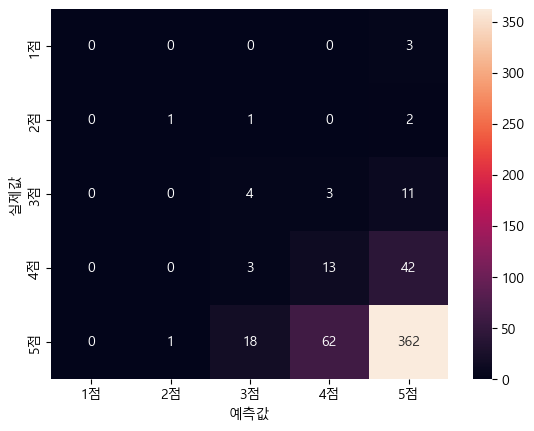

In [ ]:
labels = [1, 2, 3, 4, 5]
sns.heatmap(knn_cf, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel("예측값")
plt.ylabel("실제값")
plt.show()